In [30]:
import torch
import torchvision
from torchvision import datasets as dset
from torchvision import transforms as transforms
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import os
from pycocotools.coco import COCO
from PIL import Image
# import matplotlib.pyplot as plt

In [2]:
# set seed
torch.manual_seed(42)

In [7]:
test_tensor = torch.empty((1, 25, 300))
test_tensor[:, :test_tensor.shape[1]-1].shape

torch.Size([1, 24, 300])

It seems that we do sort of a sliding window processing of the text examples because we can only do fixed length sequence processing in the LSTM, we use words 0 until k-1 as input, and want to predict words 1 until k as target. 

In [2]:
coco = COCO('../../../data/val/annotations/captions_val2014.json')

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


In [25]:
print(coco.dataset.keys())
print(coco.cats)
print(len(coco.anns.keys()))
print(list(coco.anns.keys())[:1000][549])
print(len(coco.imgs.keys()))

dict_keys(['info', 'images', 'licenses', 'annotations'])
{}
202654
13155
40504


In [24]:
img_id = coco.anns[157]['image_id']
path = coco.loadImgs(img_id)[0]['file_name']
path

'COCO_val2014_000000478766.jpg'

(640, 480)


ValueError: Required crop size (450, 450) is larger then input image size (256, 341)

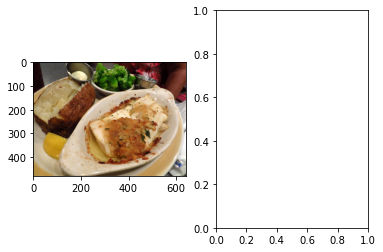

In [27]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np 

image1 = Image.open(os.path.join('../../../data/val/val2014', path)).convert('RGB')
print(image1.size)
# print(np.asarray(image1))
fig, axs = plt.subplots(nrows=1, ncols=2, squeeze=False)
ax = axs[0, 0]
ax.imshow(np.asarray(image1))
    
# plt.axis('off')
# plt.imshow(image)

transform = transforms.Compose([transforms.Resize(256), transforms.RandomCrop(450), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model, tuples for means and std for the three img channels
                         (0.229, 0.224, 0.225))])
# transforms.Compose([transforms.Resize(256)])
image2 = transform(image1)
print(image2.size())
# print(image2)
# plt.imshow(image)
ax = axs[0,1]
ax.imshow(image2.permute(1, 2, 0))

# plt.show()

plt.tight_layout()

In [26]:
coco.anns[13155]

{'image_id': 31984,
 'id': 13155,
 'caption': 'A model posing next to a motorbike at a motorcycle show.'}

In [31]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """
        Initialize pretrained Resnet 50.
        """
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        # remove the last fully connected layer
        modules = list(resnet.children())[:-1] 
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.batch= nn.BatchNorm1d(embed_size,momentum = 0.01)
        self.embed.weight.data.normal_(0., 0.02)
        self.embed.bias.data.fill_(0)
        
    def forward(self, images):
        features = self.resnet(images)
        print(features.size)
        # reshape features to shape (300, -1) - adapt to first dim
        features = features.view(features.size(0), -1)
        print("features size after view: ", features.size)
        print(features.shape)
        features = self.batch(self.embed(features))
        print("features after applying batch norm: ", features.size)
        print(features.shape)
        return features

#### New architectural points / divergence from Lazaridou
- the batchnorm layer on top of the resnet outputs
- potentially: pretrained embeddings 

In [32]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        """
        Initialize the langauge module consisting of a one-layer LSTM, a dropout layer and 
        trainable embeddings. The image embedding is used as additional context at every step of the training 
        (prepended at the embedding beginning). 
        """
        super(DecoderRNN, self).__init__()
#         _ = "~/gensim-data/fasttext-wiki-news-subwords-300/fasttext-wiki-news-subwords-300.gz"
#         self.fasttext = gensim.models.KeyedVectors.load_word2vec_format(_)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed_size= embed_size
#         self.drop_prob= 0.2
        self.vocabulary_size = vocab_size
        self.lstm = nn.LSTM(self.embed_size, self.hidden_size , self.num_layers, batch_first=True)
#         self.dropout = nn.Dropout(self.drop_prob)
        self.embed = nn.Embedding(self.vocabulary_size, self.embed_size) # .from_pretrained(
#                             torch.FloatTensor(self.fasttext.vectors)
#                         )
        self.linear = nn.Linear(hidden_size, self.vocabulary_size)
        self.embed.weight.data.uniform_(-0.1, 0.1)

    # how is the lstm initialized?
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)
    def init_hidden(self, batch_size):
        """ At the start of training, we need to initialize a hidden state;
        there will be none because the hidden state is formed based on previously seen data.
        So, this function defines a hidden state with all zeroes
        The axes semantics are (num_layers, batch_size, hidden_dim)
        """
        return (torch.zeros((1, batch_size, self.hidden_size), device=device), \
                torch.zeros((1, batch_size, self.hidden_size), device=device))
    
    def forward(self, features, captions):
        # initialize hidden layer
        # check if this isn't reinitializing the hidden state in the middle of the sequence
#         self.hidden = self.init_hidden(self.hidden_size)
        
        embeddings = self.embed(captions)
        print("LM embeddings shape original: ", embeddings.shape)
        features = features.unsqueeze(1)
        print("unsqueezed features: ", features.shape)
        # take embeddings up to last word -- WHY --> apparently to avoid predicting further when END encountered
        # PREpend the feature embedding as additional context
        
        
        embeddings = torch.cat((features, embeddings[:, :-1,:]), dim=1) # embeddings[:, :-1,:]
        print("embeddings shape after cat: ", embeddings.shape)
        # where is the previous hidden state coming from?
        hiddens, self.hidden = self.lstm(embeddings) # , self.hidden
        print("Hidden LSTM shape: ", hiddens.shape)
        print("Hidden LSTM unsqueezed shape: ", hiddens.unsqueeze(1).shape)
        
        outputs = self.linear(hiddens)
        print("outputs shape: ", outputs.shape)
        return outputs
    
    def sample(self, inputs):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        
        
        output = []
        batch_size = inputs.shape[0] # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
        hidden = self.init_hidden(batch_size) # Get initial hidden state of the LSTM
    
        while True:
            print("predicting next word")
            lstm_out, hidden = self.lstm(inputs, hidden) # lstm_out shape : (1, 1, hidden_size)
            outputs = self.linear(lstm_out)  # outputs shape : (1, 1, vocab_size)
            outputs = outputs.squeeze(1) # outputs shape : (1, vocab_size)
            _, max_indice = torch.max(outputs, dim=1) # predict the most likely next word, max_indice shape : (1)
            print("Sampled max index: ", max_indice)
            output.append(max_indice.cpu().numpy()[0].item()) # storing the word predicted
            
            if (max_indice == 1) or (len(output) == 10):
                # We predicted the <end> word, so there is no further prediction to do
                break
            
            ## Prepare to embed the last predicted word to be the new input of the lstm
            inputs = self.embed(max_indice) # inputs shape : (1, embed_size)
            inputs = inputs.unsqueeze(1) # inputs shape : (1, 1, embed_size)
            print("Inputs at end of sampling step: ", inputs.shape, " ", inputs)
            
        return output  
    
    

In [11]:
x = torch.tensor([[[1,2],[3,4],[5,6]]])
y = torch.tensor([[[7,8]]])
print(x.shape)
print(x[:, :-1, :])

torch.cat((y, x[:, :-1, :]), dim=1)


torch.Size([1, 3, 2])
tensor([[[1, 2],
         [3, 4]]])


tensor([[[7, 8],
         [1, 2],
         [3, 4]]])

Evaluate BPE tokenization.

In [1]:
# load pretrained gensim fasttext embeddings (try these because taking into account subword info might be important here)
# import gensim.downloader

# fasttext = gensim.downloader.load('fasttext-wiki-news-subwords-300')


[==================================================] 100.0% 958.5/958.4MB downloaded


AttributeError: 'KeyedVectors' object has no attribute 'wv'

In [36]:
import numpy as np
len(fasttext)
len(fasttext.key_to_index)
fasttext.index_to_key[:10]
fasttext_dict = dict()
fasttext_dict = dict(zip(np.arange(len(fasttext.index_to_key)), fasttext.index_to_key))
type(fasttext_dict)
# fasttext["Hi"]
# .get_vecattr(key, attr), .set_vecattr(key,attr,new_val)

dict

In [46]:
# fasttext_path = "~/gensim-data/fasttext-wiki-news-subwords-300/fasttext-wiki-news-subwords-300.gz"
# fasttext_loaded = gensim.models.KeyedVectors.load_word2vec_format(fasttext_path)

In [65]:
fasttext_loaded.vectors.shape
torch_fasttext = torch.FloatTensor(fasttext_loaded.vectors)
torch_fasttext

tensor([[ 0.0203, -0.0123, -0.0076,  ..., -0.0154,  0.0306,  0.0047],
        [ 0.0242,  0.0048,  0.0184,  ..., -0.0350,  0.0184,  0.0035],
        [ 0.0049, -0.0030,  0.0672,  ..., -0.0458, -0.0115,  0.0011],
        ...,
        [-0.0054,  0.0103,  0.0093,  ...,  0.0111,  0.0201,  0.0094],
        [-0.0342, -0.0159, -0.0326,  ..., -0.0076, -0.0235,  0.0224],
        [ 0.0364,  0.0182, -0.0025,  ..., -0.0063,  0.0009,  0.0487]])

At which point do i decrease the vocab size? at pretraining already?

In [33]:
# import nltk
import pickle
import os.path
from pycocotools.coco import COCO
from collections import Counter
from torchtext.data import get_tokenizer
import gensim.downloader
import numpy as np

class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="START",
        end_word="END",
        unk_word="UNK",         
        annotations_file="captions_val2014.json",
        pad_word="PAD",
        vocab_from_file=False):
        """Initialize the vocabulary.
        Args:
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.pad_word = pad_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
#         _fasttext_path = "~/gensim-data/fasttext-wiki-news-subwords-300/fasttext-wiki-news-subwords-300.gz"
#         self._fasttext = gensim.models.KeyedVectors.load_word2vec_format(_fasttext_path)
        
#         self.fasttext_word2idx = _fasttext.key_to_index
#         self.fasttext_idx2word = dict(zip(np.arange(len(_fasttext.index_to_key)), _fasttext.index_to_key))
        
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        # everything below irrelevant, if using pretrained vocab and embeddings 
        
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_word(self.pad_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {} #self._fasttext.key_to_index #{}
        self.idx2word = {} #self._fasttext.index_to_key #{}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
#             try:
#                 self.word2idx[word] = self.fasttext_word2idx[word]
#                 self.idx2word[self.fasttext_word2idx[word]] = word
#             except KeyError:
#                 self.word2idx[word] = self.fasttext_word2idx["UNK"]
#                 self.idx2word[self.fasttext_word2idx["UNK"]] = "UNK"

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokenizer = get_tokenizer("basic_english")
            tokens = tokenizer(caption.lower()) # nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [45]:
from random import shuffle
# build a batch generator which takes ones caption out of the five at random
class COCOCaptionsDataset(Dataset):
    """
    Custom class for preprocessing datapoints and sampling a random caption per image.
    """
    def __init__(self, file, download_dir, img_transform, text_transform, batch_size, mode, 
                 vocab_threshold, vocab_file, start_token, end_token, unk_token, pad_token, 
                vocab_from_file, max_sequence_length=0):
        self.transform = img_transform
        self.mode = mode # train or test or val
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, 
                                start_token, end_token, unk_token, file, pad_token, vocab_from_file) # class for instantiating the vocab object elsewhere
        self.max_sequence_length = max_sequence_length
        self.pad_token = pad_token
        
        # some distinctions below for Train and test mode
        if mode == "train":
            self.image_dir = os.path.join(download_dir, "train2014")
            self.coco = COCO(file) # os.path.join(download_dir, file)
            _ids = list(self.coco.anns.keys())
            shuffle(_ids)
            self.ids = _ids[:70000]
            print('Obtaining caption lengths...')
            tokenizer = get_tokenizer("basic_english") # nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower())
            all_tokens = [tokenizer(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in np.arange(len(self.ids))] # tqdm(np.arange(len(self.ids)))
            self.caption_lengths = [len(token) for token in all_tokens]
            # get maximum caption length for padding
            self.max_caption_length = max(self.caption_lengths)
            
            # print pretraining IDs for later separation from functional training
            with open("pretrain_img_IDs.txt", 'w') as f:
                f.write(",".join([str(i) for i in self.ids]))
                
        elif mode == "val":
            self.image_dir = os.path.join(download_dir, "val2014")
            self.coco = COCO(file) # os.path.join(download_dir, file)
            self.ids = list(self.coco.anns.keys())#[:1000]
            print('Obtaining caption lengths...')
            tokenizer = get_tokenizer("basic_english") # nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower())
            all_tokens = [tokenizer(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in np.arange(len(self.ids))] # tqdm(np.arange(len(self.ids)))
            self.caption_lengths = [len(token) for token in all_tokens]
            # get maximum caption length for padding
        else:
            
            # no annotations here 
            test_info = json.loads(open(file).read()) # os.path.join(download_dir, file)
            self.paths = [item['file_name'] for item in test_info['images']]
    
    def __len__(self):
        if self.mode != "test":
            return len(self.ids) # TODO: check if this is what we want -- it returns the number of captions, not unique imgs
        else:
            print("Test ds length: ", len(self.paths))
            return len(self.paths)
    
    def __getitem__(self, idx):
        """
        Return an image-caption tuple. The caption is sampled from the list of five captions/image at random.
        
        Arguments:
        -------
        idx: int
            Index of the item to be returned.
        """
        # TODO watch out that the same image-caption pair isn't used too often
        
        # TODO: below is rough logic, but check how to get the item at a specific instance since this is a Dataset object
#         selected_file_img, selected_file_cap = self.data[idx]
        # as can be seen above, the Dataset loader already given img-caption tuples -- check how to combine this with an index
#         cap_idx = random.sample(list(range(0,len(self.data))), 1)[0]
#         target_cap = selected_file_cap[cap_idx]
#         return (selected_file_img, target_cap)
        # obtain image and caption if in training mode
        if self.mode != 'test':
            ann_id = self.ids[idx]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.image_dir, path)).convert('RGB')
            image = self.transform(image)

            # TODO check if any other preprocessing of the caption needs to be performed
            
            tokenizer = get_tokenizer("basic_english")
            # TODO possibly shorten too long captions
            tokens = tokenizer(str(caption).lower())
            # Convert caption to tensor of word ids, append start and end tokens.
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            
            # check if the sequence needs to be padded or truncated
#             if self.max_sequence_length == 0:
#                 while len(tokens) < self.max_caption_length:
#                     tokens.append(self.pad_token)
#             else:
#                 while len(tokens) < self.max_sequence_length:
#                     tokens.append(self.pad_token)
#                 tokens = tokens[:self.max_sequence_length]
                
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
#             print("Indexed caption: ", caption)
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[idx]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.image_dir, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)
            # return original image and pre-processed image tensor
            return orig_image, image
        
    def get_train_indices(self):
        """
        Return a list of indices at which the captions have the same length which was sampled at random 
        for the given batch.
        """
        sel_length = np.random.choice(self.caption_lengths)
#         print("Sel length: ", sel_length)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
#         print("all indices: ", all_indices)
#         all_indices = list(np.arange(len(self.caption_lengths)))
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        
#         print("Indices: ", indices)
        return indices
    
    def get_func_train_indices(self):
        """
        Simple POC function returning two lists on indices, with captions of different lengths for  
        targets and distractors.
        """
        sel_length_t = np.random.choice(self.caption_lengths)
        sel_length_d = np.random.choice(self.caption_lengths)
        while sel_length_d == sel_length_t:
            sel_length_d = np.random.choice(self.caption_lengths)
#         print("Sel length: ", sel_length)
        all_indices_t = np.where([self.caption_lengths[i] == sel_length_t for i in np.arange(len(self.caption_lengths))])[0]
#         print("all indices: ", all_indices)
#         all_indices = list(np.arange(len(self.caption_lengths)))
        indices_t = list(np.random.choice(all_indices_t, size=self.batch_size))

        all_indices_d = np.where([self.caption_lengths[i] == sel_length_d for i in np.arange(len(self.caption_lengths))])[0]
        indices_d = list(np.random.choice(all_indices_d, size=self.batch_size))
        
        return list(zip(indices_t, indices_d))

In [12]:
caption_tensor.size(-1)

5

In [36]:
def get_loader(transform,
               mode='val',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="START",
               end_word="END",
               unk_word="UNK",
               pad_word="PAD",
               vocab_from_file=True,
               num_workers=0,
               download_dir="../../../data/val/",
#                cocoapi_loc='/Users/bjartesunde/Dropbox/Udacity/Computer Vision Nanodegree/computer-vision-ND/project_2_image_captioning_project/cocoapi'
              ):
    """Returns the data loader.
    Args:
      transform: Image transform.
      mode: One of 'train' or 'test'.
      batch_size: Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: Minimum word count threshold.
      vocab_file: File containing the vocabulary. 
      start_word: Special word denoting sentence start.
      end_word: Special word denoting sentence end.
      unk_word: Special word denoting unknown words.
      vocab_from_file: If False, create vocab from scratch & override any existing vocab_file.
                       If True, load vocab from from existing vocab_file, if it exists.
      num_workers: Number of subprocesses to use for data loading 
      cocoapi_loc: The location of the folder containing the COCO API: https://github.com/cocodataset/cocoapi
    """
    
    assert mode in ['train', 'test', 'val'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train' or mode=='val', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'val':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(download_dir, "val2014/") 
        annotations_file = os.path.join(download_dir, 'annotations/captions_val2014.json')
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(download_dir, "train2014/") 
        annotations_file = os.path.join(download_dir, 'annotations/captions_train2014.json')
    if mode == 'test':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join(download_dir, "val2014/") #'test2014/'
        annotations_file = os.path.join(download_dir, 'annotations/captions_val2014.json') #image_info_test2014

    # COCO caption dataset.
    dataset = COCOCaptionsDataset(
        file=annotations_file,
        download_dir = download_dir, 
        img_transform=transform,
        text_transform=None,
        batch_size=batch_size,
        mode=mode,
        vocab_threshold=vocab_threshold,
        vocab_file=vocab_file,
        start_token=start_word,
        end_token=end_word,
        unk_token=unk_word,
        pad_token=pad_word, 
        vocab_from_file=vocab_from_file,
        max_sequence_length=25,
    )
    

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=torch.utils.data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = torch.utils.data.DataLoader(dataset=dataset,
                           
           batch_size=dataset.batch_size,
                                      shuffle=True,
#                                       num_workers=num_workers
                                                 )

    return data_loader

trimming / padding -- check conceptually. For now, max caption length treated as target length.


In [50]:
from torchvision import transforms
import numpy as np

vocab_threshold = 6
batch_size = 128
transform_train = transforms.Resize(256)
# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='val',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False,
                        )
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))


loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
[0/202654] Tokenizing captions...
[100000/202654] Tokenizing captions...
[200000/202654] Tokenizing captions...
loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
Obtaining caption lengths...
Total number of tokens in vocabulary: 5914


In [11]:
print("Max caption length: ", data_loader.dataset.max_caption_length)
print("Average caption length in words: ", sum(data_loader.dataset.caption_lengths)/len(data_loader.dataset.caption_lengths))

Max caption length:  56
Average caption length in words:  11.307761011379


In [15]:
sorted(Counter(data_loader.dataset.caption_lengths).items(), key=lambda pair: pair[1], reverse=True)
# --> cut off at 25 tokens, pad to 25 the ones that are shorter.

[(10, 42089),
 (11, 39220),
 (9, 34922),
 (12, 28137),
 (13, 18356),
 (14, 11081),
 (8, 10202),
 (15, 6562),
 (16, 3799),
 (17, 2410),
 (18, 1506),
 (19, 995),
 (7, 817),
 (20, 676),
 (21, 495),
 (22, 324),
 (23, 238),
 (24, 214),
 (25, 131),
 (26, 89),
 (27, 66),
 (28, 56),
 (29, 41),
 (30, 39),
 (31, 28),
 (32, 19),
 (34, 14),
 (33, 13),
 (40, 12),
 (35, 12),
 (37, 11),
 (38, 10),
 (45, 9),
 (36, 9),
 (43, 8),
 (39, 6),
 (46, 6),
 (48, 5),
 (50, 4),
 (47, 4),
 (53, 3),
 (6, 3),
 (44, 3),
 (41, 3),
 (51, 2),
 (52, 1),
 (42, 1),
 (54, 1),
 (56, 1),
 (49, 1)]

In [70]:
dict(list(data_loader.dataset.vocab.word2idx.items())[:15])

{'START': 39235,
 'END': 44803,
 'UNK': 77808,
 'PAD': 52948,
 'a': 7,
 'bicycle': 10888,
 'replica': 19413,
 'with': 17,
 'clock': 5154,
 'as': 18,
 'the': 1,
 'front': 1586,
 'wheel': 6203,
 '.': 2,
 'black': 882}

In [37]:
import torch
import torch.nn as nn
from torchvision import transforms
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
# from data_loader import get_loader
# from model import EncoderCNN, DecoderRNN
import math


## TODO #1: Select appropriate values for the Python variables below.
batch_size = 64         # batch size
vocab_threshold = 1        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 1             # number of training epochs (1 for testing)
save_every = 1             # determines frequency of saving model weights
print_every = 200          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.lstm.parameters()) + list(decoder.linear.parameters()) + list(encoder.embed.parameters()) + list(encoder.batch.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)
print(total_step)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.55s)
creating index...
index created!
Obtaining caption lengths...
1094


In [6]:
x = torch.randn(4, 4)
print(x)
print(x[:, :-1])
x[:, :x.shape[1]-1]
# print(x.size())
# print(x.shape)
# y = x.view(16)
# print(y.size())
# print(y.shape)
# z = x.view(-1)  # the size -1 is inferred from other dimensions
# print(z.size())
# print(z.shape)

# a = torch.randn(1, 2, 3, 4)
# a.size()
# b = a.transpose(1, 2)  # Swaps 2nd and 3rd dimension
# b.size()
# c = a.view(1, 3, 2, 4)  # Does not change tensor layout in memory
# c.size()
# torch.equal(b, c)

tensor([[-0.2054,  0.7625, -0.7968, -0.1389],
        [-0.5942,  0.7384, -0.1585,  0.2094],
        [ 0.2012,  1.1229,  1.1435, -1.9726],
        [ 1.8615,  1.1492,  1.0917, -1.0409]])
tensor([[-0.2054,  0.7625, -0.7968],
        [-0.5942,  0.7384, -0.1585],
        [ 0.2012,  1.1229,  1.1435],
        [ 1.8615,  1.1492,  1.0917]])


tensor([[-0.2054,  0.7625, -0.7968],
        [-0.5942,  0.7384, -0.1585],
        [ 0.2012,  1.1229,  1.1435],
        [ 1.8615,  1.1492,  1.0917]])

In [14]:
torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-test.pkl' ))
torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-test.pkl' ))

In [15]:
import json 
transform_test = transforms.Compose([transforms.Resize((224, 224)), \
                                     transforms.ToTensor(), \
                                     transforms.Normalize((0.485, 0.456, 0.406), \
                                                          (0.229, 0.224, 0.225))])
data_loader_test = get_loader(transform=transform_test,    
                         mode='test')


Vocabulary successfully loaded from vocab.pkl file!
Test ds length:  40504
Test ds length:  40504


Test ds length:  40504
Test ds length:  40504


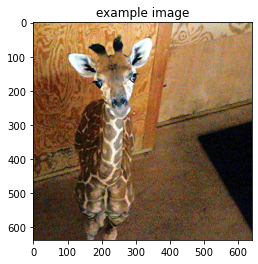

In [16]:
import matplotlib.pyplot as plt
orig_image, image = next(iter(data_loader_test))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [18]:
# def get_prediction():
#     orig_image, image = next(iter(data_loader))
#     plt.imshow(np.squeeze(orig_image))
#     plt.title('Sample Image')
#     plt.show()
encoder.eval()
decoder.eval()
image = image.to(device)
features = encoder(image).unsqueeze(1)
output = decoder.sample(features)    
sentence = clean_sentence(output)
print(sentence)

predicting next word
Sampled max index:  tensor([2])
Inputs at end of sampling step:  torch.Size([1, 1, 512])   tensor([[[ 0.0275, -0.1055,  0.0283, -0.0303,  0.1047,  0.0389,  0.0570,
           0.0558,  0.0180, -0.0252, -0.0077,  0.0940,  0.0687, -0.0621,
          -0.0146, -0.0147,  0.0210,  0.0748,  0.0172, -0.0930, -0.0848,
           0.0877,  0.0950, -0.0789,  0.0941, -0.0880,  0.0539,  0.0089,
          -0.0291,  0.0903, -0.0564, -0.0306, -0.0757, -0.0999,  0.0364,
          -0.0858,  0.0714,  0.0193, -0.0731, -0.0257,  0.0198, -0.0568,
          -0.0782,  0.0462,  0.0975,  0.0955, -0.0401,  0.0169, -0.0339,
          -0.0688,  0.0629,  0.0481, -0.0331,  0.0544,  0.0782, -0.0971,
           0.0579,  0.0271,  0.0602,  0.0571,  0.0890, -0.0478, -0.0903,
           0.0136,  0.0592,  0.1003, -0.0701, -0.0591, -0.0016,  0.0470,
          -0.0110, -0.0484, -0.0384, -0.0359, -0.0733, -0.0858,  0.0858,
           0.0469,  0.0783, -0.0280, -0.0642, -0.0725,  0.0269, -0.0145,
           0

In [110]:
encoder_file = 'encoder-1.pkl' 
decoder_file = 'decoder-1.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
visual_embed_size = 1024
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(visual_embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (lstm): LSTM(512, 512, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (embed): Embedding(5913, 512)
  (linear): Linear(in_features=512, out_features=5913, bias=True)
)

In [113]:
image = image.to(device)

# Obtain the embedded image features.
print("image.shape: ", image.shape)
features = encoder(image).unsqueeze(1)
print("features.shape: ", features.shape)
print()

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

image.shape:  torch.Size([1, 3, 224, 224])
features.shape:  torch.Size([1, 1, 512])



KeyboardInterrupt: 

In [17]:
def clean_sentence(output):
    list_string = []
    
    for idx in output:
        list_string.append(data_loader.dataset.vocab.idx2word[idx])
    
    list_string = list_string[1:-1] # Discard <start> and <end> words
    sentence = ' '.join(list_string) # Convert list of string to full string
    sentence = sentence.capitalize()  # Capitalize the first letter of the first word
    return sentence

# sentence = clean_sentence(output)
# print('example sentence:\n', sentence)

In [38]:
# training set up 

## TODO #1: Select appropriate values for the Python variables below.
batch_size = 128         # batch size
vocab_threshold = 1        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 1024           # dimensionality of word embeddings
visual_embed_size = 1024   # dimensionality of the image embeding
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 1             # number of training epochs (1 for testing)
save_every = 1             # determines frequency of saving model weights
print_every = 200          # determines window for printing average loss
log_file = 'training_log_train.txt'       # name of file with saved training loss and perplexity

# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file,
                         download_dir="../../../data/train", 
                        )

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)
print(vocab_size)


Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
Obtaining caption lengths...
24701


In [39]:
# Initialize the encoder and decoder. 
encoder = EncoderCNN(visual_embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.lstm.parameters()) + list(decoder.linear.parameters()) + list(encoder.embed.parameters()) + list(encoder.batch.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08)



In [40]:
import math
# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)
print(total_step)

547


In [43]:
import time
import sys

# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
                
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        print("Training Loop captions shape: ", captions.shape)
        
        # Zero the gradients (reset).
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        print("Outputs shape: ", outputs.shape)
        print("Outputs: ", outputs)
        
        # Calculate the batch loss.
#         print("target shape before view: ", captions.shape)
        print("target shape original: ", captions.view(-1).shape)
#         print("target shape transformed: ", captions[:, 1:].reshape(-1).shape)
        print("Outputs shape: ", outputs.contiguous().view(-1, vocab_size).shape)
        
        loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.reshape(-1))
        print("Loss", loss)
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

# Close the training log file.
f.close()

Indexed caption:  [0, 34, 1363, 14, 2817, 2818, 41, 208, 752, 4, 149, 1]
Indexed caption:  [0, 4, 61, 15, 702, 202, 88, 87, 88, 7, 58, 1]
Indexed caption:  [0, 4, 62, 903, 4, 1431, 622, 2400, 7, 4, 810, 1]
Indexed caption:  [0, 49, 1709, 730, 22, 374, 2689, 887, 479, 1227, 19, 1]
Indexed caption:  [0, 4, 125, 903, 132, 41, 4, 269, 283, 2166, 19, 1]
Indexed caption:  [0, 4, 443, 14, 583, 8180, 228, 41, 4, 134, 520, 1]
Indexed caption:  [0, 483, 1566, 1652, 110, 165, 1696, 4, 7110, 414, 19, 1]
Indexed caption:  [0, 34, 1128, 14, 1467, 132, 500, 41, 4, 114, 19, 1]
Indexed caption:  [0, 4, 810, 340, 334, 41, 262, 14, 4, 1431, 19, 1]
Indexed caption:  [0, 4, 213, 972, 107, 4, 61, 32, 2124, 165, 48, 1]
Indexed caption:  [0, 4, 4370, 14, 3565, 210, 79, 4, 233, 794, 19, 1]
Indexed caption:  [0, 52, 8180, 228, 103, 4, 1119, 79, 34, 138, 19, 1]
Indexed caption:  [0, 52, 179, 583, 8180, 409, 471, 4, 378, 1865, 19, 1]
Indexed caption:  [0, 4, 92, 132, 260, 34, 261, 79, 34, 588, 19, 1]
Indexed capt

Indexed caption:  [0, 4, 86, 1058, 132, 372, 165, 4, 283, 2256, 19, 1]
Indexed caption:  [0, 4, 378, 1672, 627, 4, 35, 22, 52, 1833, 4600, 1]
Indexed caption:  [0, 4, 338, 14, 2659, 174, 372, 165, 74, 419, 19, 1]
Indexed caption:  [0, 4, 379, 132, 1641, 41, 4, 62, 219, 903, 19, 1]
Indexed caption:  [0, 4, 890, 332, 334, 372, 165, 4, 155, 7, 236, 1]
Indexed caption:  [0, 256, 352, 7, 52, 1627, 54, 957, 73, 4, 342, 1]
Indexed caption:  [0, 4, 82, 14, 53, 41, 4, 208, 363, 951, 19, 1]
Indexed caption:  [0, 4, 24191, 2029, 14, 4, 1443, 1953, 368, 787, 19, 1]
Indexed caption:  [0, 4, 82, 14, 465, 41, 4, 208, 363, 951, 19, 1]
Indexed caption:  [0, 4, 173, 22, 4, 1653, 363, 1566, 113, 34, 785, 1]
Training Loop captions shape:  torch.Size([128, 12])
<built-in method size of Tensor object at 0x7ff07303ebf0>
features size after view:  <built-in method size of Tensor object at 0x7ff08210ce30>
torch.Size([128, 2048])
features after applying batch norm:  <built-in method size of Tensor object at 0x7

Indexed caption:  [0, 4, 173, 790, 4, 18645, 414, 752, 4, 1566, 2445, 19, 1]
Indexed caption:  [0, 379, 228, 79, 123, 4, 1292, 368, 4, 61, 38, 19, 1]
Indexed caption:  [0, 4, 2525, 1652, 502, 4, 791, 2586, 113, 4, 9703, 19, 1]
Indexed caption:  [0, 4, 21, 851, 22, 4, 3427, 7, 2805, 41, 48, 19, 1]
Indexed caption:  [0, 4, 94, 179, 79, 4, 272, 930, 368, 4, 2053, 19, 1]
Indexed caption:  [0, 4, 888, 1253, 56, 34, 2719, 81, 4, 213, 214, 19, 1]
Indexed caption:  [0, 4, 173, 132, 79, 4, 1059, 7, 1389, 79, 4, 27, 1]
Indexed caption:  [0, 4, 173, 179, 79, 62, 3024, 722, 869, 4, 535, 19, 1]
Indexed caption:  [0, 4, 258, 186, 368, 4, 1566, 1653, 41, 4, 1566, 19755, 1]
Indexed caption:  [0, 374, 621, 7, 62, 888, 7737, 4, 208, 7, 4, 453, 1]
Indexed caption:  [0, 4, 35, 116, 81, 4, 1119, 79, 62, 7, 21, 19, 1]
Indexed caption:  [0, 34, 2065, 132, 2447, 41, 4, 958, 14, 457, 500, 19, 1]
Indexed caption:  [0, 4, 100, 79, 4, 8950, 849, 7, 1368, 22, 571, 19, 1]
Indexed caption:  [0, 4, 931, 133, 372, 165

Epoch [1/1], Step [2/547], Loss: 9.7537, Perplexity: 17217.3124Indexed caption:  [0, 255, 132, 4, 173, 141, 4, 142, 79, 4, 724, 1]
Indexed caption:  [0, 168, 14, 4, 58, 7, 59, 79, 4, 11, 19, 1]
Indexed caption:  [0, 4, 4370, 14, 4652, 54, 137, 81, 3322, 12633, 19, 1]
Indexed caption:  [0, 4, 136, 191, 568, 4, 1058, 10589, 79, 4, 8009, 1]
Indexed caption:  [0, 4, 4002, 107, 4, 826, 1188, 235, 22, 509, 19, 1]
Indexed caption:  [0, 4, 244, 888, 66, 132, 1022, 56, 4, 888, 2044, 1]
Indexed caption:  [0, 4, 343, 82, 14, 878, 54, 41, 34, 42, 19, 1]
Indexed caption:  [0, 3987, 7, 3266, 955, 73, 3455, 79, 4, 1438, 19, 1]
Indexed caption:  [0, 4, 621, 931, 133, 103, 34, 1717, 41, 4, 35, 1]
Indexed caption:  [0, 52, 109, 54, 55, 56, 34, 234, 22, 2592, 19, 1]
Indexed caption:  [0, 4, 109, 517, 132, 1966, 722, 165, 52, 2671, 19, 1]
Indexed caption:  [0, 2659, 3892, 22, 1762, 446, 269, 1119, 79, 1763, 19, 1]
Indexed caption:  [0, 4, 82, 14, 53, 141, 325, 33, 4, 719, 19, 1]
Indexed caption:  [0, 34, 

Indexed caption:  [0, 4, 37, 169, 170, 290, 3404, 41, 4, 233, 35, 1]
Indexed caption:  [0, 4, 810, 132, 322, 299, 41, 4, 277, 500, 19, 1]
Indexed caption:  [0, 4, 62, 7, 21, 117, 228, 79, 4, 903, 19, 1]
Indexed caption:  [0, 4, 371, 174, 22, 4, 617, 362, 79, 386, 19, 1]
Indexed caption:  [0, 4, 1566, 1652, 132, 363, 1566, 79, 34, 449, 19, 1]
Indexed caption:  [0, 4, 117, 66, 132, 331, 56, 41, 4, 700, 19, 1]
Indexed caption:  [0, 1350, 498, 22, 383, 3234, 932, 41, 233, 35, 19, 1]
Indexed caption:  [0, 4, 340, 622, 107, 203, 916, 7, 419, 1243, 19, 1]
Training Loop captions shape:  torch.Size([128, 12])
<built-in method size of Tensor object at 0x7ff0820fd950>
features size after view:  <built-in method size of Tensor object at 0x7ff0820fdc50>
torch.Size([128, 2048])
features after applying batch norm:  <built-in method size of Tensor object at 0x7ff0820fd830>
torch.Size([128, 1024])
LM embeddings shape original:  torch.Size([128, 12, 1024])
unsqueezed features:  torch.Size([128, 1, 1024]

Indexed caption:  [0, 140, 132, 702, 644, 34, 8809, 66, 798, 79, 34, 2545, 592, 19, 1]
Indexed caption:  [0, 4, 82, 14, 625, 1612, 22, 18749, 41, 737, 79, 4, 1304, 19, 1]
Indexed caption:  [0, 4, 61, 94, 132, 345, 4, 874, 41, 4, 958, 14, 1040, 19, 1]
Indexed caption:  [0, 4, 766, 195, 22, 4, 332, 88, 52, 12121, 594, 7, 278, 19, 1]
Indexed caption:  [0, 4, 173, 594, 41, 4, 406, 180, 4, 464, 12441, 579, 373, 19, 1]
Indexed caption:  [0, 52, 53, 174, 79, 123, 14, 4, 100, 518, 4, 1273, 1368, 19, 1]
Indexed caption:  [0, 4, 371, 736, 299, 129, 180, 4, 395, 2753, 79, 34, 683, 19, 1]
Indexed caption:  [0, 4, 621, 7, 37, 888, 976, 372, 165, 4, 62, 7, 21, 888, 1]
Indexed caption:  [0, 4, 42, 32, 7, 169, 170, 228, 79, 526, 435, 34, 42, 19, 1]
Indexed caption:  [0, 1315, 116, 3038, 165, 377, 180, 1397, 79, 34, 539, 9885, 34, 2299, 1]
Indexed caption:  [0, 4, 258, 173, 141, 4, 776, 56, 34, 189, 14, 4, 862, 19, 1]
Indexed caption:  [0, 4, 379, 4137, 253, 41, 34, 138, 22, 164, 5126, 732, 253, 19, 1]

KeyboardInterrupt: 

## Reference game setting

Here, the speaker is initialized with the pretrained model. Then, it is: 
* put in "inference mode", 
* i.e., we sample a caption until the END token was sampled
* this is transformed to the NL message (or can we skip this step? the tok2idx transformation is normally happening in the get_item call, but we probably don't need getting the sample here)
* this is input into an encoder lstm (i.e., (1, len(sent))
* the image embedding is created with the same visual encoder (here, it also has a hidden size of 512 - to match the lstm hidden size)
* output lstm vector before linear layer, reshaped to the same shape as the visual embedding, to allow computing similarity

Then, the training loop is the most complicated thing. We need to combine the computation of the cross entropy loss with reinforce here. Furthermore, I need to check how to backpropagate to the speaker model, when it is set in "inference" mode. Maybe I can use @grad, or similar (analogous to .no_grad())?

In [54]:
class ListenerEncoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        """
        Initialize the langauge module consisting of a one-layer LSTM, a dropout layer and 
        trainable embeddings. The image embedding is used as additional context at every step of the training 
        (prepended at the embedding beginning). 
        """
        super(ListenerEncoderRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed_size= embed_size
        self.vocabulary_size = vocab_size
        # not sure if this will be pretrained
        self.embed = nn.Embedding(self.vocabulary_size, self.embed_size) # .from_pretrained(
#                             torch.FloatTensor(self.fasttext.vectors)
#                         )

        self.lstm = nn.LSTM(self.embed_size, self.hidden_size , self.num_layers, batch_first=True)
        # reshape into a vector of (1, 512), such that similarity with the image can be computed
        self.linear = nn.Linear(hidden_size, 1)
        self.embed.weight.data.uniform_(-0.1, 0.1)

    # how is the lstm initialized?
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)
    def init_hidden(self, batch_size):
        """ At the start of training, we need to initialize a hidden state;
        there will be none because the hidden state is formed based on previously seen data.
        So, this function defines a hidden state with all zeroes
        The axes semantics are (num_layers, batch_size, hidden_dim)
        """
        return (torch.zeros((1, batch_size, self.hidden_size), device=device), \
                torch.zeros((1, batch_size, self.hidden_size), device=device))
    
    def forward(self, captions):
        # initialize hidden layer
        # check if this isn't reinitializing the hidden state in the middle of the sequence
#         self.hidden = self.init_hidden(self.hidden_size)
        
        embeddings = self.embed(captions)
        print("LSTM encoder embeddings shape: ", embeddings.shape)
        # where is the previous hidden state coming from?
        hiddens, self.hidden = self.lstm(embeddings) # , self.hidden
        outputs = self.linear(hiddens)
        print("LSTM encoder outputs shape: ", outputs.shape)
        return outputs

In [52]:
class ListenerEncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """
        Initialize pretrained Resnet 50.
        """
        super(ListenerEncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        # remove the last fully connected layer
        modules = list(resnet.children())[:-1] 
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.batch= nn.BatchNorm1d(embed_size,momentum = 0.01)
        self.embed.weight.data.normal_(0., 0.02)
        self.embed.bias.data.fill_(0)
        
    def forward(self, images, caption):
        features1 = self.resnet(images[0])
        features2 = self.resnet(images[1])
        # reshape features to shape (300, -1) - adapt to first dim
        features1 = features1.view(features1.size(0), -1)
        features1 = self.batch(self.embed(features1))
        features2 = features2.view(features2.size(0), -1)
        features2 = self.batch(self.embed(features2))
        # compute dot product between images and caption
        dot_products_1 = torch.bmm(features1.view(images.size()[0], 1, features1.size()[1]),
                                   caption.view(images.size()[0], features1.size()[1], 1))
        dot_products_2 = torch.bmm(features2.view(images.size()[0], 1, features2.size()[1]),
                                   caption.view(images.size()[0], features2.size()[1], 1))
        # compose targets and distractors dot products
        pairs = torch.stack((features1, features2), dim=1) # stack into pairs, assuming dim=0 is the batch dimension
        pairs_flat = pairs.squeeze(-1).squeeze(-1)
        # get out a tensor with indices of the larger dot product, tensor of shape (batch,)
        out = torch.argmax(pairs_flat, dim=1)
        return out

In [46]:
class COCOCaptionsDataset_functional(COCOCaptionsDataset):
    
    def __getitem__(self, idx):
        """
        Return an image-caption tuple. The caption is sampled from the list of five captions/image at random.

        Arguments:
        -------
        idx: (int, int)
            Index of the target and distractor items to be returned.
        """
        # TODO watch out that the same image-caption pair isn't used too often

        # obtain image and caption if in training mode
        if self.mode != 'test':
            # sample target index
            target = np.random.choice([0,1])
            target_idx = idx[target]
            distractor_idx = idx[(1-target)]

            ann_id = self.ids[target_idx]
            target_caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            target_path = self.coco.loadImgs(img_id)[0]['file_name']

            # get distarctor
            dist_id = self.ids[distractor_idx]
            dist_img_id = self.coco.anns[dist_id]['image_id']
            distractor_path = self.coco.loadImgs(dist_img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            target_image = Image.open(os.path.join(self.image_dir, target_path)).convert('RGB')
            target_image = self.transform(target_image)

            distractor_image = Image.open(os.path.join(self.image_dir, distractor_path)).convert('RGB')
            distractor_image = self.transform(distractor_image)

            # TODO check if any other preprocessing of the caption needs to be performed

            tokenizer = get_tokenizer("basic_english")
            # TODO possibly shorten too long captions
            tokens = tokenizer(str(target_caption).lower())
            # Convert caption to tensor of word ids, append start and end tokens.
            target_caption = []
            target_caption.append(self.vocab(self.vocab.start_word))

            # check if the sequence needs to be padded or truncated
#             if self.max_sequence_length == 0:
#                 while len(tokens) < self.max_caption_length:
#                     tokens.append(self.pad_token)
#             else:
#                 while len(tokens) < self.max_sequence_length:
#                     tokens.append(self.pad_token)
#                 tokens = tokens[:self.max_sequence_length]

            target_caption.extend([self.vocab(token) for token in tokens])
            target_caption.append(self.vocab(self.vocab.end_word))
#             print("Indexed caption: ", caption)
            target_caption = torch.Tensor(target_caption).long()

            # return pre-processed image and caption tensors
            return (target_image, distractor_image), target_caption, target

        # obtain image if in test mode
        else:
            path = self.paths[idx]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.image_dir, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)
            # return original image and pre-processed image tensor
            return orig_image, image

In [48]:
def get_loader_functional(transform,
               mode='val',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="START",
               end_word="END",
               unk_word="UNK",
               pad_word="PAD",
               vocab_from_file=True,
               num_workers=0,
               download_dir="../../../data/val/",
#                cocoapi_loc='/Users/bjartesunde/Dropbox/Udacity/Computer Vision Nanodegree/computer-vision-ND/project_2_image_captioning_project/cocoapi'
              ):
    """Returns the data loader.
    Args:
      transform: Image transform.
      mode: One of 'train' or 'test'.
      batch_size: Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: Minimum word count threshold.
      vocab_file: File containing the vocabulary. 
      start_word: Special word denoting sentence start.
      end_word: Special word denoting sentence end.
      unk_word: Special word denoting unknown words.
      vocab_from_file: If False, create vocab from scratch & override any existing vocab_file.
                       If True, load vocab from from existing vocab_file, if it exists.
      num_workers: Number of subprocesses to use for data loading 
      cocoapi_loc: The location of the folder containing the COCO API: https://github.com/cocodataset/cocoapi
    """
    
    assert mode in ['train', 'test', 'val'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train' or mode=='val', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'val':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(download_dir, "val2014/") 
        annotations_file = os.path.join(download_dir, 'annotations/captions_val2014.json')
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(download_dir, "train2014/") 
        annotations_file = os.path.join(download_dir, 'annotations/captions_train2014.json')
    if mode == 'test':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join(download_dir, "val2014/") #'test2014/'
        annotations_file = os.path.join(download_dir, 'annotations/captions_val2014.json') #image_info_test2014

    # COCO caption dataset.
    dataset = COCOCaptionsDataset_functional(
        file=annotations_file,
        download_dir = download_dir, 
        img_transform=transform,
        text_transform=None,
        batch_size=batch_size,
        mode=mode,
        vocab_threshold=vocab_threshold,
        vocab_file=vocab_file,
        start_token=start_word,
        end_token=end_word,
        unk_token=unk_word,
        pad_token=pad_word, 
        vocab_from_file=vocab_from_file,
        max_sequence_length=25,
    )
    

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=torch.utils.data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = torch.utils.data.DataLoader(dataset=dataset,
                           
           batch_size=dataset.batch_size,
                                      shuffle=True,
#                                       num_workers=num_workers
                                                 )

    return data_loader

In [49]:
# define a data loader returning two images
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader_pairs = get_loader_functional(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file,
                         download_dir="../../../data/train", 
                        )


Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
Obtaining caption lengths...


In [55]:
# reference game training loop

# instantiate litener models

listener_embed_size = 512
vocab_threshold = 1        # minimum word count threshold
vocab_from_file = False    # if True, load existing vocab file
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 1             # number of training epochs (1 for testing)
save_every = 1             # determines frequency of saving model weights
print_every = 200          # determines window for printing average loss
log_file = 'listener_log_train.txt'       # name of file with saved training loss and perplexity

# vocab size should be the same as for speaker / pretrained model

listener_encoder = ListenerEncoderCNN(listener_embed_size)
listener_rnn = ListenerEncoderRNN(listener_embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
listener_encoder.to(device)
listener_rnn.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(listener_rnn.lstm.parameters()) + list(listener_rnn.linear.parameters()) + list(listener_encoder.embed.parameters()) + list(listener_encoder.batch.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)

maybe i can override the getitem fct to take tuples of indices and return two images from the dataset. this would allow for the dataloader to take a list on tuple indices, and not instantiate two data loaders on separate index lists

Feed the message embedding right into the Encoder CNN, compute embeddings on pairs, compute dot product similarities for the pairs and output a tensor with shape (batch, 2), the second being a list with scores over the target, i.e. [1,0] if first image is the target, [0,1] is vice versa. The data loader just needs to sample something like `(img1, img2), [1,0], caption for target img`. 

Then cross entropy can be applied straight on the output of the encoder net. Only question - does the target need to be the list [1,0] or just the index (0)?

I don't think i need to call .eval() on the speaker model - i just need to call decoder.sample(features) instead of decoder(features, captions)

In [56]:
for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        # TODO: also retriveing the distractor captions and reinstantiating the dataloader seems 
        # rather inefficient w r t memory / runtime 
        
        # Randomly sample a caption length, and sample indices with that length.
        indices_pairs = data_loader_pairs.dataset.get_func_train_indices()
        
        # Create and assign a batch sampler to retrieve a target batch with the sampled indices.
        new_sampler_pairs = torch.utils.data.sampler.SubsetRandomSampler(indices=indices_pairs)
        
        #####
        # just turn the indices passed in here into tuples for target + dist (zipped or something)
        # and modify __getitem__ to accept tuples
        # sample at random in the __getitem__ method whether the first or second image is target,
        # return respective caption and index
#         new_sampler_distractor = torch.utils.data.sampler.SubsetRandomSampler(indices=indices_distrctors)
        data_loader_pairs.batch_sampler.sampler = new_sampler_pairs
        ######
        
        # Obtain the target batch.
        images, captions, targets = next(iter(data_loader_pairs))
        
#         (target_image, distractor_image), target_caption, target 


        ## batch will the look like image_tuples, caption, target_ind = next(iter(data_loader))
        ## modify listener CNN encoder to accept tuple of images, message embedding

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        targets = targets.to(device)
#         print("Training Loop captions shape: ", captions.shape)
        
        # Zero the gradients (reset).
        listener_encoder.zero_grad()
        listener_rnn.zero_grad()
        
        # Pass the targets through the CNN-RNN model.
        outputs = listener_rnn(captions)
        
        predictions = listener_encoder(images, outputs) # TODO - make this images, outputs
        
        
        #######
        # Pass the distractors through the CNN
        # TODO: check if really needs re-initialization / how to design the data_loader better
        
        data_loader_distractor.batch_sampler.sampler = new_sampler_distractor
        images_distractor, _ = next(iter(data_loader_distractor))
        images_distractor = images_distractor.to(device)
        features_distractor = listener_encoder(images_distractor)
        ######
        print("GOT THROUGH STEP: ", i_step)
        # compute the dot product similarity between each image and caption encoding
        
        
        # TODO instatiate the notion of target smh
        
        # Calculate the batch loss.
        
        # REINFORCE for functional part, applied to speaker LSTM weights (maybe also Linear ones)
        # cross entropy for Listener LSTM and Linear
        # and also cross entropy for Speaker params, optimizing against target caption of the target image
        # (last implemented just like for pretraining)
        
#         loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.reshape(-1))
        
        # REWARD
        # if target index and output index match, 1, else -1
        
        # Backward pass.
#         loss.backward()
        
        # Update the parameters in the optimizer.
#         optimizer.step()
            
        # Get training statistics.
#         stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
#         # Print training statistics (on same line).
#         print('\r' + stats, end="")
#         sys.stdout.flush()
        
        # Print training statistics to file.
#         f.write(stats + '\n')
#         f.flush()
        
        # Print training statistics (on different line).
#         if i_step % print_every == 0:
#             print('\r' + stats)
            
    # Save the weights.
#     if epoch % save_every == 0:
#         torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
#         torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

# Close the training log file.
f.close()

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>